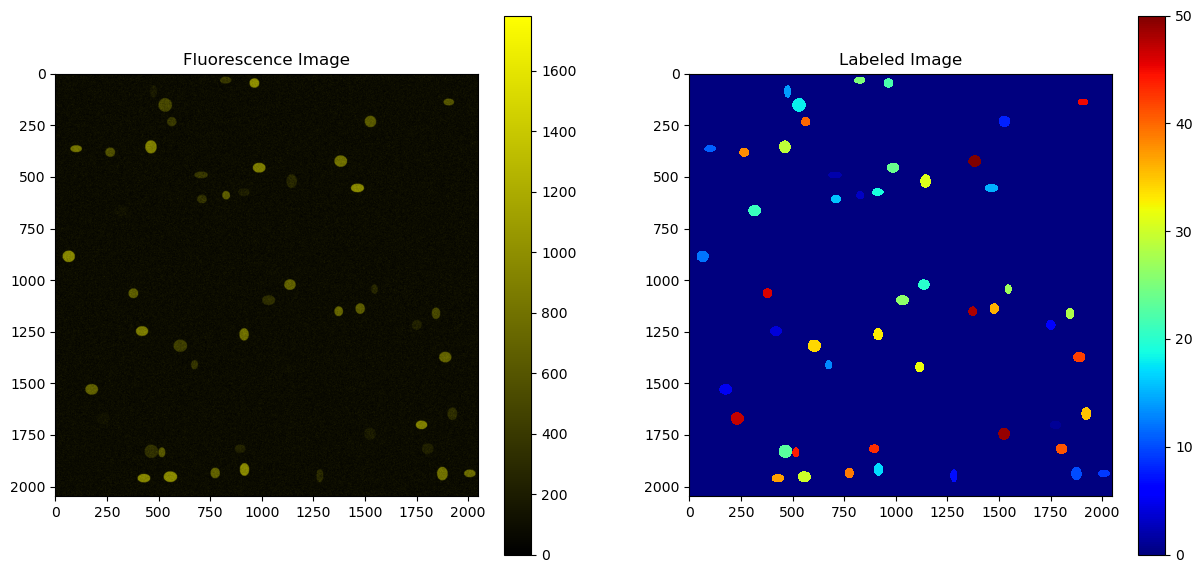

Number of objects detected: 50


In [3]:
import numpy as np
from skimage import filters, util
from skimage.filters import gaussian
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from skimage.draw import ellipse

def generate_realistic_cell(size, fluorescence_level):
    """
    Generates a single oval-shaped cell with random radii to simulate realistic yeast cells.
    """
    major_axis = size[0] * np.random.uniform(0.985, 0.99)  # Randomize the major axis
    minor_axis = size[1] * np.random.uniform(0.985, 0.99)  # Randomize the minor axis

    cell_image = np.zeros((int(major_axis*4), int(minor_axis*4)), dtype=np.uint16)
    rr, cc = ellipse(int(major_axis*2), int(minor_axis*2), int(major_axis*1.8), int(minor_axis*1.8), shape=cell_image.shape)
    cell_image[rr, cc] = fluorescence_level
    return cell_image


def place_realistic_cells(image_size, num_cells, cell_properties):
    fluorescence_image = np.zeros(image_size, dtype=np.uint16)
    labelled_image = np.zeros(image_size, dtype=np.uint8)
    label_index = 1

    for props in cell_properties:
        cell_image = generate_realistic_cell(props['size'], props['fluorescence_level'])
        cell_height, cell_width = cell_image.shape
        x = np.random.randint(0, image_size[1] - cell_width + 1)
        y = np.random.randint(0, image_size[0] - cell_height + 1)

        # Place the cell in the fluorescence image
        fluorescence_image[y:y + cell_height, x:x + cell_width] = np.maximum(fluorescence_image[y:y + cell_height, x:x + cell_width], cell_image)

        # Place the label in the labeled image (solid color)
        cell_mask = cell_image > 0
        labelled_image[y:y + cell_height, x:x + cell_width][cell_mask] = label_index
        label_index += 1

    # Apply Gaussian blur to simulate optical system blur
    fluorescence_image = gaussian(fluorescence_image, sigma=1)

    # Add reduced Gaussian noise for realism
    fluorescence_image = util.random_noise(fluorescence_image, mode='gaussian', var=0.00001)

    # Scale the image back to uint16 after adding noise
    fluorescence_image = np.clip(fluorescence_image * 65535, 0, 65535).astype(np.uint16)

    return fluorescence_image, labelled_image

# Custom colormap for fluorescence image (black to yellow)

#COmment below code, if you don't want this output_images
# This will run as a test before your Input in Example Script Code like a test run
# Set image and cell properties for realistic yeast fluorescence images
cmap_fluorescence = mcolors.LinearSegmentedColormap.from_list('black_yellow', ['black', 'yellow'])
image_size = (2048, 2048)
num_cells = 50
cell_properties = [{'size': (np.random.randint(10, 20), np.random.randint(10, 20)),
                    'fluorescence_level': np.random.randint(1000, )} for _ in range(num_cells)]

# Generate the fluorescence image and corresponding labeled image
fluorescence_image, labelled_image = place_realistic_cells(image_size, num_cells, cell_properties)

# Display the fluorescence image with the yellow colormap
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
cax1 = ax[0].imshow(fluorescence_image, cmap=cmap_fluorescence)
fig.colorbar(cax1, ax=ax[0], orientation='vertical')
ax[0].set_title('Fluorescence Image')

# Display the labeled image with a scale and black background
cax2 = ax[1].imshow(labelled_image, cmap=plt.cm.jet, interpolation='nearest')
fig.colorbar(cax2, ax=ax[1], orientation='vertical')
ax[1].set_title('Labeled Image')

plt.show()

print(f"Number of objects detected: {num_cells}")
